In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
import numpy as np

import pandoramoon as pandora
from pandoramoon.helpers import ld_convert, ld_invert

import ultranest
import ultranest.stepsampler
from ultranest import ReactiveNestedSampler
from ultranest.plot import cornerplot

import pickle
import math
import random
import os

from wotan import flatten, t14
from statsmodels.stats import stattools

Get parameters of stable architectures (no resonance)

In [63]:
sim_no = 236
# f = open('/home/garvit/Downloads/Exomoon_project/sim_data/july13_res/TTVsim{}_system_dictionary.pkl'.format(sim_no), 'rb')
f = open('/home/garvit/Downloads/Exomoon_project/sim_data/may10_nores/TTVsim{}_system_dictionary.pkl'.format(sim_no), 'rb')


sim_params= pickle.load(f)
sim_params


{'Planet': {'m': 1.3982713717525024e+25,
  'Rp': 8416856.879999999,
  'Rstar': 493947000.0,
  'RpRstar': 0.01704,
  'rhostar': 2914.794655619886,
  'impact': 0.039264752723498275,
  'q1': 0.40411449000000005,
  'q2': 0.2892873997168476,
  'a': 131171197452.33594,
  'Pp': 348.6182434374297,
  'rhoplan': 5598.259543975825,
  'aRp': None,
  'e': None,
  'inc': None,
  'pomega': None,
  'f': None,
  'P': 30120616.232993927,
  'RHill': 1926412748.3253655},
 'I': {'m': 2.893946014840926e+21,
  'r': 821490.6544712327,
  'msmp': 0.00020696597765667207,
  'rsrp': 0.09760064430027861,
  'a': 72607741.12710458,
  'aRp': 8.626467357385383,
  'e': 0.0,
  'inc': 0.16549994302214466,
  'pomega': 4.650022129525847,
  'f': 2.7761888876007013,
  'P': 127236.21015647978,
  'RHill': 2977891.206631242,
  'spacing': 'linear',
  'period_ratio': nan},
 'II': {'m': 9.955174291052775e+21,
  'r': 808246.5417335822,
  'msmp': 0.0007119629631389512,
  'rsrp': 0.09602712191223362,
  'a': 136521145.10965937,
  'aRp'

Feed parameters into a pandora model

In [64]:
params = pandora.model_params()
params.R_star = sim_params['Planet']['Rstar'] # [m]	 
params.u1 = 2*sim_params['Planet']['q2']*np.sqrt(sim_params['Planet']['q1'])
params.u2 = -2*(sim_params['Planet']['q2'] - 0.5) * np.sqrt(sim_params['Planet']['q1'])

Planet parameters:

In [65]:
params.per_bary = sim_params['Planet']['Pp']  # [days]
params.a_bary = sim_params['Planet']['a']/params.R_star  # [R_star]
params.r_planet = sim_params['Planet']['RpRstar'] # [R_star]
params.b_bary = sim_params['Planet']['impact']   # [0..1]
params.t0_bary = 10  # [days]
params.t0_bary_offset = 0.0 #0.01  # [days]
params.M_planet =  sim_params['Planet']['m'] # [kg]

w_bary = sim_params['Planet']['pomega']
params.w_bary = math.degrees(w_bary) if w_bary!=None else random.random()*2*np.pi  # [deg]
ecc_bary= sim_params['Planet']['e']
params.ecc_bary = ecc_bary if ecc_bary!=None else 0  # [0..1]  



Other Parameters. Using short cadence to obtain TTVs

In [66]:
num_moons = len(sim_params.keys()) - 1

params.epochs = 30  # [int]
params.epoch_duration = 6  # [days]
params.cadences_per_day = 30000 # [int]
params.epoch_distance = params.per_bary   # [days]
params.supersampling_factor = 1  # [int]
params.occult_small_threshold = 0.1  # [0..1]
params.hill_sphere_threshold = 1.2

N_epoch = params.epoch_duration*params.cadences_per_day
N = params.epochs* N_epoch
TTs= np.ndarray((num_moons+1, params.epochs)) #array for Transit Times
TTVs= np.ndarray((num_moons, params.epochs)) #Transit Timing Variations
flux_moons= np.ndarray((num_moons, N))



Plug moon parameters and obtain light curve(s) of individual moon(s). From them obtain transit-times of the planet for each moon. 

In [84]:
for i in range(num_moons):
    moon_key = list(sim_params.keys())[i+1]
    params.r_moon = sim_params[moon_key]['r']/params.R_star  # [R_star]
    params.per_moon = sim_params[moon_key]['P']/(24*3600) # [days]
    params.a_moon = sim_params[moon_key]['a']/params.R_star  # [R_star]
    params.tau_moon = (2*np.pi-sim_params[moon_key]['f'])/(2*np.pi)  # [0..1]
    params.Omega_moon = random.random() * 2*np.pi  # [0..180]
    params.i_moon = math.degrees(sim_params[moon_key]['inc'])%360  # [0..180]
    params.e_moon = sim_params[moon_key]['e']  # [0..1]
    params.w_moon = math.degrees(sim_params[moon_key]['pomega'])  # [deg]
    params.M_moon = sim_params[moon_key]['m']  #kg

    # if(i==3):
    #     G = 6.67408e-11
    #     day = 60 * 60 * 24

    #     a_moon = (G * (params.M_planet + params.M_moon) * ((params.per_moon * day)/(2 * np.pi))**2)**(1 / 3)
    #     a_moon/= params.R_star

    #     delta_t = params.per_bary/(2*np.pi) * (a_moon/params.a_bary) * (params.M_moon/params.M_planet)

    #     print(delta_t)

    time = pandora.time(params).grid()
    model = pandora.moon_model(params)

    flux_total, flux_planet, flux_moons[i] = model.light_curve(time)

    for j in range(params.epochs):
        TTs[i+1][j] = time[j* N_epoch + np.nanargmin(flux_planet[j*N_epoch:(j+1)*N_epoch])]


Obtain transit-times for planet with no moon

In [85]:
params.M_moon = 1e-8
model = pandora.moon_model(params)
flux_total, flux_planet_only, flux_moon = model.light_curve(time)

for j in range(params.epochs):
     TTs[0][j] = time[j* N_epoch + np.nanargmin(flux_planet_only[j*N_epoch:(j+1)*N_epoch])]

np.set_printoptions(precision=15)
#print(TTs)


Fit straight line to the transit-times and obtain TTVs

In [86]:
x = [i for i in range(params.epochs)]
for i in range(num_moons):
    line_fit = np.polyfit(x, y=TTs[i+1], deg=1)
    TTVs[i] = TTs[i+1] - np.polyval(line_fit, x)

    
    # if(i==1):
    #     plt.scatter(x, TTs[i+1], color='red', label='transit times')
    #     plt.plot( np.polyval(line_fit, x), label='best fit line')
    #     plt.xlabel('epochs')
    #     plt.legend()
    

TTV_planet_allmoons = np.sum(TTVs, axis=0)
#print(TTs)
#print(TTV_planet_allmoons)
TT_planet_allmoons = np.add(TTV_planet_allmoons, TTs[0])
#print(TT_planet_allmoons)


Obtain long cadence light-curves for injection

In [87]:
# params.cadences_per_day = 48 #kepler cadence # [int]
# N_epoch = params.epoch_duration*params.cadences_per_day
# N = params.epochs* N_epoch

# flux_moons= np.ndarray((num_moons, N))

# for i in range(num_moons):
#     moon_key = list(sim_params.keys())[i+1]
#     params.r_moon = sim_params[moon_key]['r']/params.R_star  # [R_star]
#     params.per_moon = sim_params[moon_key]['P']/(24*3600) # [days]
#     params.tau_moon = (2*np.pi-sim_params[moon_key]['f'])/(2*np.pi)  # [0..1]
#     params.Omega_moon = random.random() * 2*np.pi  # [0..180]
#     params.i_moon = math.degrees(sim_params[moon_key]['inc'])%360  # [0..180]
#     params.e_moon = sim_params[moon_key]['e']  # [0..1]
#     params.w_moon = math.degrees(sim_params[moon_key]['pomega'])  # [deg]
#     params.M_moon = sim_params[moon_key]['m']   # [0..1]

#     time = pandora.time(params).grid()
#     model = pandora.moon_model(params)

#     flux_total, flux_planet, flux_moons[i] = model.light_curve(time)


# params.M_moon = 1e-8
# model = pandora.moon_model(params)
# flux_total, flux_planet_only, flux_moon = model.light_curve(time)

TTV-adjust the planet-only light curve to obtain all-moon light curve for the planet.

In [88]:

def shift(arr, delta=0, fill_value=1.0):
    result = np.empty_like(arr)
    if delta > 0:
        result[:delta] = fill_value
        result[delta:] = arr[:-delta]
    elif delta < 0:
        result[delta:] = fill_value
        result[:delta] = arr[-delta:]
    else:
        result[:] = arr
    
    return result

flux_planet_allmoons = np.empty_like(flux_planet_only)
for i in range(params.epochs):
    transit = flux_planet_only[i*N_epoch:(i+1)*N_epoch]
    delta = int(np.round(TTV_planet_allmoons[i] * params.cadences_per_day))
    #print(delta)
    flux_planet_allmoons[i*N_epoch:(i+1)*N_epoch] = shift(transit, delta)


Get total flux of planet + moons

In [89]:
flux_total = np.copy(flux_planet_allmoons) 
for i in range(num_moons): flux_total+= flux_moons[i]
flux_total-=(num_moons)


Plot light curves of the planet and all moons:

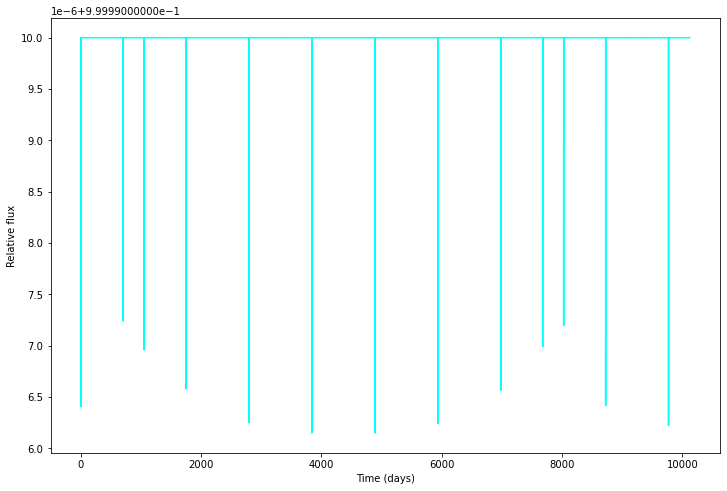

In [90]:
moon_labels=['I', 'II', 'III', 'IV', 'V']
colors=['red', 'green', 'brown','purple','cyan']

#plt.plot(time, flux_planet_allmoons, color="blue", label='planet')

# for i in range(num_moons):
#     plt.plot(time, flux_moons[i], color=colors[i], label= 'moon {}'.format(moon_labels[i]))
plt.plot(time, flux_moons[4], color=colors[i], label= 'moon {}'.format(moon_labels[i]))
    
#plt.plot(time, flux_total, color="black", label='total flux')

#plt.ylim(.99999, 1.000001)
#plt.xlim(min(time)+0*params.epoch_distance, min(time)+0*params.epoch_distance+ params.epoch_duration)
plt.xlabel("Time (days)")
plt.ylabel("Relative flux")
#plt.legend()
plt.show()

Let us have a look at the transits more closely:

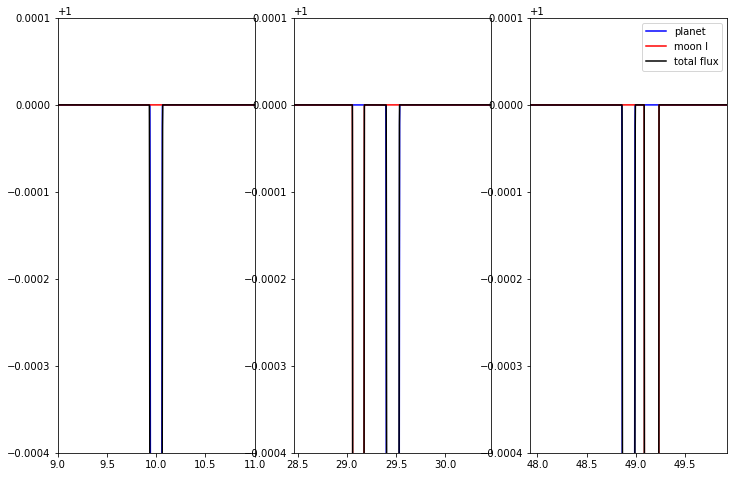

In [59]:
moon_labels=['I', 'II', 'III', 'IV', 'V']
colors=['red', 'green', 'brown','purple','cyan']

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.plot(time, flux_planet, color="blue", label='planet')
for i in range(num_moons):
    ax1.plot(time, flux_moons[i], color=colors[i], label= 'moon {}'.format(moon_labels[i]))
ax1.plot(time, flux_total, color="black", label='total flux')
ax1.set_xlim(min(time), min(time)+params.epoch_duration)
ax1.set_ylim(.9996, 1.0001)

ax2.plot(time, flux_planet, color="blue", label='planet')
for i in range(num_moons):
    ax2.plot(time, flux_moons[i], color=colors[i], label= 'moon {}'.format(moon_labels[i]))
ax2.plot(time, flux_total, color="black", label='total flux')
ax2.set_xlim(min(time)+params.epoch_distance, min(time)+params.epoch_duration+params.epoch_distance)
ax2.set_ylim(.9996, 1.0001)

ax3.plot(time, flux_planet, color="blue", label='planet')
for i in range(num_moons):
    ax3.plot(time, flux_moons[i], color=colors[i], label= 'moon {}'.format(moon_labels[i]))
ax3.plot(time, flux_total, color="black", label='total flux')
ax3.set_xlim(min(time)+2*params.epoch_distance, min(time)+params.epoch_duration+2*params.epoch_distance)
ax3.set_ylim(.9996, 1.0001)

plt.legend()
plt.show()

Define function for injection. It will first rebin the model light curve to kepler's cadence

In [60]:
def find_nearest(array, value):
    if(math.isnan(value)): return float('nan')
    
    array = np.asarray(array)
    idx = np.nanargmin(np.abs(array - value))
    return idx


def inject(data, timestamps, model_lc, time):

    time1= time + timestamps[0] - time[0]
    rebinned_flux = []
    rebinned_time = []
   
    i =0
    for j in range(timestamps.shape[0]-1):
        print(j)

        if(math.isnan(timestamps[j+1])):
            nexti = find_nearest(time1, timestamps[0]+(j+1)*(1/48))

        else:
            nexti = find_nearest(time1, timestamps[j+1])
        
        if(np.abs(time1[i] - timestamps[j]) <0.01 and np.abs(time1[nexti] - timestamps[j+1]) <0.01):
            if(math.isnan(timestamps[j+1])):
                rebinned_flux.append(float('nan'))
                rebinned_time.append(float('nan'))

            else:
                rebinned_flux.append(np.mean(model_lc[ i: nexti]))
                rebinned_time.append(timestamps[j])
            

        i = nexti        

    rebinned_flux = np.array(rebinned_flux)
    rebinned_time = np.array(rebinned_time)

    injected_lc = np.copy(data)

    for i in range(rebinned_time.shape[0]):
        injected_lc[np.where(timestamps == rebinned_time[i])] *= rebinned_flux[i]
    
    return injected_lc


def mask(array ):

    kepler_cadence = 48 #per day
    mask_size = 2*int(transit_duration* kepler_cadence)

    offset = timestamps[0] - time[0]
    
    indices = []
    for i in range(params.epochs): 
        indices.append(find_nearest(timestamps, TT_planet_allmoons[i]+ offset))

    slices = []
    
    if(indices[0] - int(mask_size/2) >0): slices.append(array[: indices[0] - int(mask_size/2)])

    for i in range(params.epochs-1):
        slices.append(array[indices[i] + int(mask_size/2) : indices[i+1] - int(mask_size/2) ])

    slices.append(array[indices[-1] + int(mask_size/2) : ])

    masked = np.concatenate(slices)

    return masked



In [12]:
G = 6.67408e-11
day = 60 * 60 * 24

M_star = ((4 * np.pi ** 2 / G) * ((params.a_bary * params.R_star) ** 3)) / (params.per_bary * day) ** 2

R_sun = 696340000
M_sun = 1.989e+30

transit_duration = t14(R_s = params.R_star/R_sun, M_s = M_star/M_sun, P = params.per_bary, small_planet=True)
detrending_window = 3 * transit_duration
detrending_window

2.0312024704256393

Get no-planet kepler light curve with low magnitude and good Durbin-Watson statistic 

In [13]:
#f = open('/home/garvit/Downloads/Exomoon_project/good_kepler_data.txt','w')

#os.system("ls /home/garvit/Downloads/Exomoon_project/no_planet_lightcurves/ > temp")
#lightcurves_files = open('temp', 'r').read().split('\n')
lightcurves_files = open('/home/garvit/Downloads/Exomoon_project/good_kepler_data.txt', 'r').read().split('\n')

i=0
while True:
    if(i== len(lightcurves_files)-1): break

    data = open("/home/garvit/Downloads/Exomoon_project/no_planet_lightcurves/{}".format(lightcurves_files[i]), 'r').readlines()
    print(lightcurves_files[i])
    # if(float(data[1].split('\t')[4]) > 13.0 ): 
    #     i+=1
    #     continue

    N = len(data) -1
    flux = np.ndarray((N))
    timestamps = np.ndarray((N))

    for j in range(N):
        timestamps[j] = float(data[j+1].split('\t')[0])
        flux[j] = float(data[j+1].split('\t')[1])


    #injected_flux = inject(flux, timestamps, flux_total, time)
    
    detrended_flux, trend = flatten(timestamps, flux, method = 'biweight', window_length=detrending_window, return_trend=True)

#     residual = injected_flux - trend
#     masked_residual = mask(residual)

#     print(stattools.durbin_watson(masked_residual[np.logical_not(np.isnan(masked_residual))]))
#     # if(abs(stattools.durbin_watson(masked_residual[np.logical_not(np.isnan(masked_residual))]) - 2.0) < 0.5 ):
#     #     f.write(lightcurves_files[i]+'\n')

#     i+=1

    break    

#f.close()

KIC10983462_lightcurve.txt


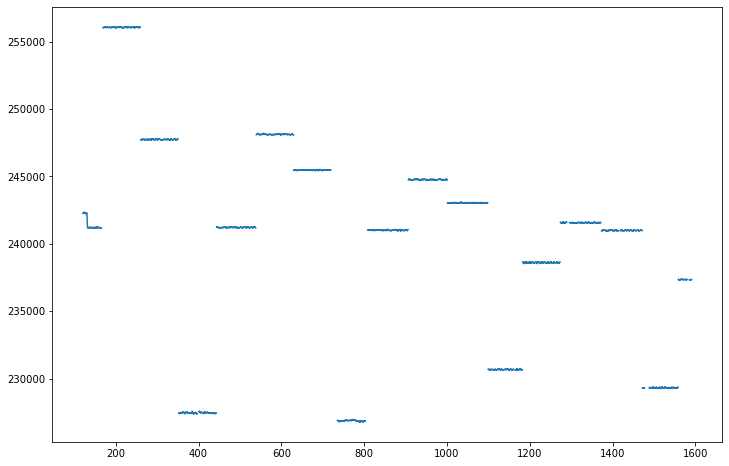

In [15]:
plt.plot(timestamps, trend)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


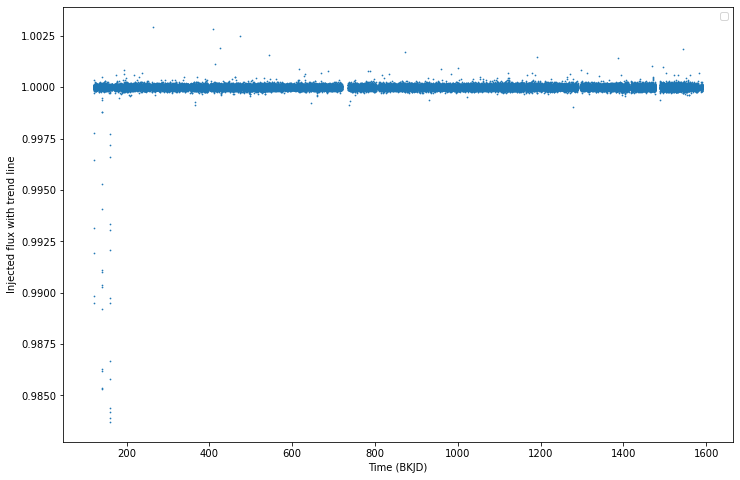

In [40]:
#plt.scatter(timestamps, injected_flux, s=0.5)
#plt.plot(timestamps, trend, color='orange', label='trend line')

plt.scatter(timestamps, detrended_flux, s=0.5) 
plt.xlabel('Time (BKJD)')
plt.ylabel('Injected flux with trend line')
#plt.ylabel('detrended flux without injection')
#plt.xlim(115,128)
plt.legend()

#detrended_flux, trend = flatten(timestamps, injected_flux, method = 'biweight', window_length=detrending_window, return_trend=True)
#plt.scatter([i for i in range(len(residual))], residual, s=1)

In [8]:

data = open("/home/garvit/Downloads/Exomoon_project/no_planet_lightcurves3/kic757137_kepler_lightcurve.tsv").readlines()

N = len(data) -1
flux = np.ndarray((N))
timestamps = np.ndarray((N))

for j in range(N):
    timestamps[j] = float(data[j+1].split('\t')[0])
    flux[j] = float(data[j+1].split('\t')[1])



In [44]:
sim_no = 680 
res_nores = 'res'
num_moons = 5

f = open("/media/Datas/Exomoon_project/model_LCs/{}_{}_{}.txt".format(sim_no, res_nores, 'july13'), 'r')
model_data = f.readlines()
f.close()

flux_planet_allmoons = np.ndarray((len(model_data) - 1))
time = np.ndarray((len(model_data)-1))
flux_moons = np.ndarray((num_moons, len(model_data)-1))

for j in range(len(model_data)-1):
    time[j] = float(model_data[j+1].split('\t')[0])
    flux_planet_allmoons[j] = float(model_data[j+1].split('\t')[1])
    for i in range(num_moons):
        flux_moons[i][j] = float(model_data[j+1].split('\t')[2+i])

4172


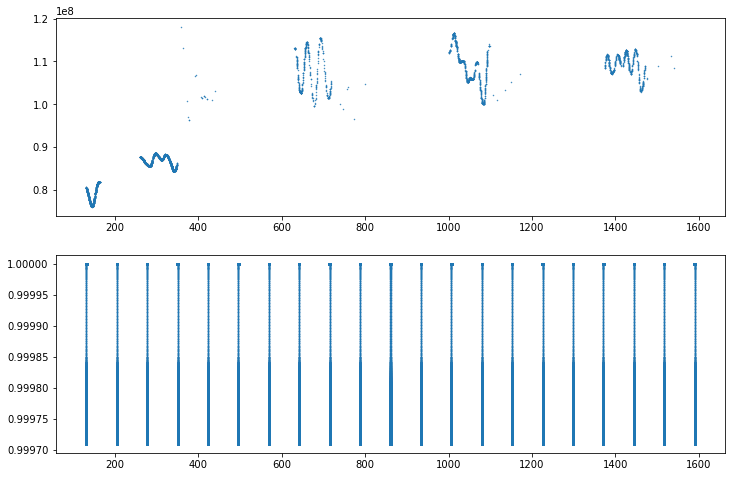

In [52]:
print(N)

ax1 = plt.subplot(2,1,1)
plt.scatter(timestamps, flux, s=0.2)

plt.subplot(2,1,2, sharex = ax1)
plt.scatter(time-time[0]+timestamps[0], flux_planet_allmoons, s=0.2)

#plt.xlim(275,280)


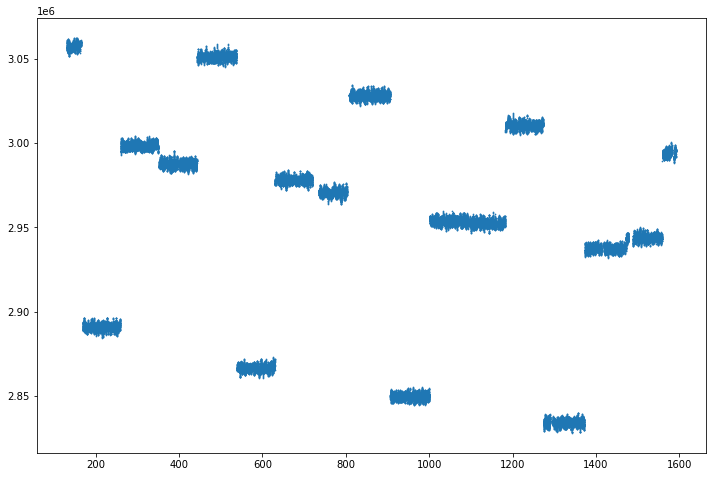

In [10]:
plt.scatter(timestamps, flux, s=0.5)